In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

OUTPUT_PATH = r'./models/git_out'
os.makedirs(OUTPUT_PATH, exist_ok=True)  # ✅ Correct function


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf

E0000 00:00:1766434153.076501      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766434153.185348      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import math
import cv2
import numpy as np
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output
from tensorflow.keras.layers import Conv2D, Dense, LeakyReLU, BatchNormalization, UpSampling2D, Add,\
    AveragePooling2D, Concatenate, Input, Lambda, Activation, LayerNormalization
from tensorflow.keras import Model, Sequential

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 64
N_BLOCK = 2
EPOCHS = 50
CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCH = 5

In [4]:
LOG_DIR = './results/logs/'
CKPT_DIR = './results/models_weight'

In [5]:
inp_data_path = pathlib.Path('/kaggle/input/animefacedataset/images')
file_list = [str(path) for path in inp_data_path.glob('*.jpg')]

In [6]:
def preprocess(file_path, img_size=IMG_SIZE):
    imgs = tf.io.read_file(file_path)
    imgs = tf.io.decode_jpeg(imgs, channels=3)
    imgs = tf.image.resize(imgs, [img_size, img_size])

    imgs = tf.image.convert_image_dtype(imgs, dtype=tf.float32)
    imgs = (imgs - 127.5) / 127.5
    return imgs


data_path = tf.data.Dataset.from_tensor_slices(file_list)
train_data = data_path.map(preprocess).shuffle(500).batch(BATCH_SIZE)
test_data = data_path.map(preprocess).shuffle(500).batch(16)

I0000 00:00:1766434172.128178      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766434172.128900      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


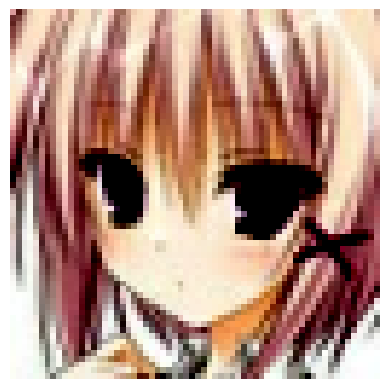

In [7]:
img = next(iter(train_data))

plt.imshow(img[0])
plt.axis('off')
plt.show()

In [8]:
timesteps = 1000

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)


def add_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), [-1, 1, 1, 1])
    one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), [-1, 1, 1, 1])
    noisy_img = sqrt_alpha_bar_t  * x_0 + one_minus_sqrt_alpha_bar_t  * noise
    return noisy_img, noise

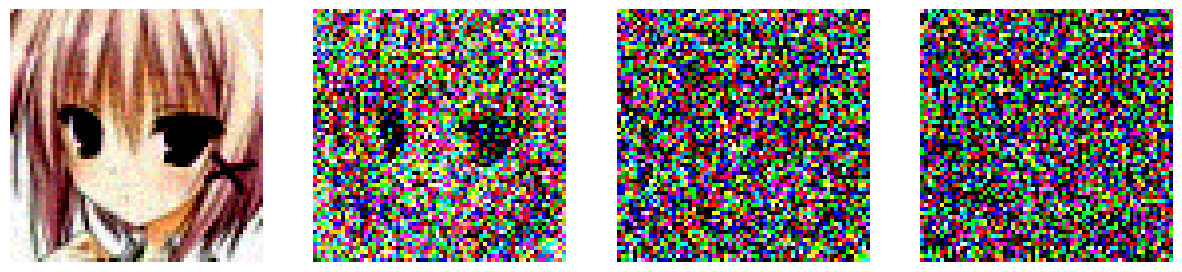

In [9]:
fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 300, 600, 900]):
    noisy_im, noise = add_noise(img[0], np.array([i,]))
    noisy_im = np.squeeze(noisy_im)
    plt.subplot(1, 4, index+1)
    plt.axis('off')
    plt.imshow(noisy_im)

plt.savefig('image.png')
plt.show()

In [10]:
# Linear Attention Layer
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.dim_head = dim_head
        self.hidden_dim = dim_head * heads

        self.to_qkv = Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = Sequential([
            Conv2D(filters=dim, kernel_size=1, strides=1),
            LayerNormalization()
        ])

    def call(self, x, training=True):
        residual = x
        b, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]

        qkv = self.to_qkv(x)
        q, k, v = tf.split(qkv, num_or_size_splits=3, axis=-1)

        q = tf.reshape(q, [b, h*w, self.heads, self.dim_head])
        k = tf.reshape(k, [b, h*w, self.heads, self.dim_head])
        v = tf.reshape(v, [b, h*w, self.heads, self.dim_head])

        q = tf.nn.softmax(q, axis=1)  # softmax over sequence
        k = tf.nn.softmax(k, axis=1)
        q = q * self.scale

        context = tf.einsum('b n h d, b n h e -> b h d e', k, v)
        out = tf.einsum('b h d e, b n h d -> b n h e', context, q)
        out = tf.reshape(out, [b, h, w, self.hidden_dim])
        out = self.to_out(out, training=training)

        return out + residual


In [11]:
# Residual Block
def resBlock(inp, filter, t):
    residual = inp
    if inp.shape[-1] != filter:
        residual = Conv2D(filter, 1, padding='same')(inp)

    x = Conv2D(filter, 3, padding='same')(inp)
    x = tf.keras.layers.GroupNormalization(groups=8, epsilon=1e-5)(x)

    t_dense = Dense(filter*2)(t)
    # Wrap tf.split in a Lambda layer
    gamma, beta = tf.keras.layers.Lambda(lambda z: tf.split(z, num_or_size_splits=2, axis=-1))(t_dense)
    x = x * (gamma + 1) + beta
    x = Activation('swish')(x)

    x = Conv2D(filter, 3, padding='same')(x)
    x = tf.keras.layers.GroupNormalization(groups=8, epsilon=1e-5)(x)
    x = Activation('swish')(x)

    out = Add()([x, residual])
    return out

# Down Block
def downBlock(x, skips, filter, n_block, t):
    for _ in range(n_block):
        x = resBlock(x, filter, t)
        skips.append(x)
    x = LinearAttention(filter)(x)
    x = AveragePooling2D(pool_size=2)(x)
    return x

# Up Block
def upBlock(x, skips, filter, n_block, t):
    x = UpSampling2D(size=2)(x)
    for _ in range(n_block):
        x = Concatenate()([x, skips.pop()])
        x = resBlock(x, filter, t)
    x = LinearAttention(filter)(x)
    return x

In [12]:
# Sinusoidal Positional Embedding
class SinusoidalPosEmb(tf.keras.layers.Layer):
    def __init__(self, dim=32, max_positions=10000):
        super().__init__()
        self.dim = dim
        self.max_positions = max_positions
        self.dense1 = Dense(self.dim, activation='swish')
        self.dense2 = Dense(self.dim, activation='swish')

    def call(self, x):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        emb = tf.reshape(emb, [-1, 1, 1, self.dim])
        emb = self.dense1(emb)
        emb = self.dense2(emb)
        return emb

In [13]:
# U-Net
def U_NET(img_size, N_BLOCK=2):
    noisy_img = Input(img_size)
    time = Input((1,))

    e = SinusoidalPosEmb()(time)
    x = Conv2D(32, 1, padding='same')(noisy_img)
    skips = []

    x = downBlock(x, skips, 64, N_BLOCK, e)
    x = downBlock(x, skips, 128, N_BLOCK, e)
    x = downBlock(x, skips, 128, N_BLOCK, e)

    for _ in range(N_BLOCK):
        x = resBlock(x, 256, e)

    x = upBlock(x, skips, 128, N_BLOCK, e)
    x = upBlock(x, skips, 128, N_BLOCK, e)
    x = upBlock(x, skips, 64, N_BLOCK, e)
    x = resBlock(x, 32, e)

    out = Conv2D(3, 1, padding='same', kernel_initializer="zeros")(x)
    return Model([noisy_img, time], out)

In [14]:
u_net = U_NET((64, 64, 3))

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

ckpt = tf.train.Checkpoint(u_net=u_net)

# save model
summary_Writer = tf.summary.create_file_writer(LOG_DIR)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH + 1
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [16]:
OUTPUT_PATH = r'./models/git_out'


if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH, exist_ok=True)

def ddim(x_t, pred_noise, t, step_size):
    alpha_t_bar = np.reshape(np.take(alpha_bar, t), [-1, 1, 1, 1])
    alpha_t_minus_one = np.reshape(np.take(alpha_bar, t-step_size), [-1, 1, 1, 1])

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one) ** 0.5) * pred_noise
    return pred

inference_timesteps = 200
inference_range = range(0, timesteps, timesteps // inference_timesteps)
inf_step = timesteps // inference_timesteps

def generate_save_img(epoch, path=OUTPUT_PATH, save=True):
    x = tf.random.normal((16,64,64,3))
    for index, i in enumerate(reversed(range(inference_timesteps))):
        t = np.repeat(inference_range[i], 16)
        t = tf.constant(t, dtype=tf.int32) # Convert t to a TensorFlow tensor

        pred_noise = u_net([x, t])
        x = ddim(x, pred_noise, t, inf_step)

        if any(t-inf_step) == 0:
            break

    for i in range(x.shape[0]):
        axs = plt.subplot(4, 4, i+1)
        axs.imshow(x[i] * 0.5 + 0.5)
        plt.axis('off')

    if save:
        plt.savefig(os.path.join(path, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

In [17]:
def train_step(inp_img):
    t_size = inp_img.shape[0]
    t = tf.random.uniform(shape=[t_size,], minval=0, maxval=timesteps, dtype=tf.int32)
    noisy_img, noise = add_noise(inp_img, t)

    with tf.GradientTape() as tape:
        pre_noise = u_net([noisy_img, t])
        loss = loss_fn(pre_noise, noise)

    gradients = tape.gradient(loss, u_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_net.trainable_variables))
    return loss


In [18]:
u_net.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinusoidal_pos_emb  │ (None, 1, 1, 32)  │      2,112 │ input_layer_1[0]… │
│ (SinusoidalPosEmb)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 128) │      4,224 │ sinusoidal_pos_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 1, 1,     │          0 │ dense_2[0][0]     │
│                     │ 64), (None, 1, 1, │            │                   │
│                     │ 64)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 64)  │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ group_normalizat… │
│                     │ 64)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ multiply[0][0],   │
│                     │ 64)               │            │ lambda[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ activation_1[0][… │
│                     │ 64)               │            │ conv2d_1[0][0]  

 Total params: 6,179,331 (23.57 MB)

 Trainable params: 6,179,331 (23.57 MB)

 Non-trainable params: 0 (0.00 B)

Saving checkpoint for epoch 50 at ./results/models_weight/ckpt-10
epoch 50 loss is 0.03454902768135071 

Time taken for epoch 50 is 175.31342363357544 sec



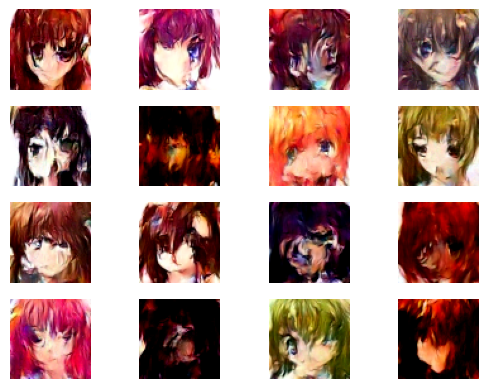

In [19]:
import time

for epoch in range(CURRENT_EPOCH, EPOCHS+1):

    start = time.time()
    print('Start of epoch {}'.format(epoch))

    losses = []
    for step, data in enumerate(train_data):

        loss = train_step(data)
        losses.append(loss)

        if step % 10 == 0:
            print('.', end='')

        if step > 100:
            break

    print('\n Epoch {} finished: '.format(epoch))
    with summary_Writer.as_default():
        tf.summary.scalar('loss', np.mean(losses), step=epoch)

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        clear_output(wait=True)

        #save model
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))

    print ('epoch {} loss is {} \n'.format(epoch,np.mean(losses)))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,time.time()-start))
    generate_save_img(epoch)
